In [26]:
!pip install pycaret[full]

zsh:1: no matches found: pycaret[full]


In [449]:
import numpy as np
import pandas as pd

from pycaret.regression import *
from pycaret.utils import *
from sklearn.metrics import mean_squared_error
import datetime

In [457]:
BASE_COLUMNS = ['running_time', 'route_distance_km', 'delta_time', 'min_distance', 'max_distance', 'mean_distance', 'std_distance', 'min_speed', 'max_speed', 'mean_speed', 'std_speed']
FEATURE_COLUMNS = ['is_rush_hour']
CATEGORICAL_COLUMNS = []
USELESS_COLUMNS = ['node_start', 'node_finish', 'lon_start', 'lon_end', 'lat_end', 'lat_start', 'average_speed']

INCLUDE_COLUMNS = [*CATEGORICAL_COLUMNS, *FEATURE_COLUMNS, *BASE_COLUMNS]

In [458]:
dataset = pd.read_csv('datasets/big-table-train.csv')
dataset = dataset.dropna()
dataset = dataset.drop(columns=[*USELESS_COLUMNS, 'completed_time'])

dataset

,Id,running_time,route_distance_km,delta_time,distance,speed,is_work_hour,is_night_time,is_late_night_time,is_rush_hour,humidity,visibility,windspeedKmph,tempC,weatherStatus
0,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,31.771489,30.0,1,0,0,1,87,10,18,-4,Light snow
3,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,50.034390,29.0,1,0,0,1,87,10,18,-4,Light snow
4,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,13.453126,30.0,1,0,0,1,87,10,18,-4,Light snow
5,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,15.994386,32.0,1,0,0,1,87,10,18,-4,Light snow
7,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,47.897295,30.0,1,0,0,1,87,10,18,-4,Light snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401289,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,4.477717,42.0,0,0,1,0,85,10,23,-5,Clear
401290,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,28.463251,42.0,0,0,1,0,85,10,23,-5,Clear
401291,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,31.753756,30.0,0,0,1,0,85,10,23,-5,Clear
401294,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,59.467195,41.0,0,0,1,0,85,10,23,-5,Clear


In [459]:
dataset_agg = dataset.groupby([*CATEGORICAL_COLUMNS, *FEATURE_COLUMNS, *['Id', 'running_time', 'route_distance_km', 'delta_time']]) \
    .agg({'distance': ['min', 'max', 'mean', 'std'], 'speed': ['min', 'max', 'mean', 'std']}).reset_index()

dataset_agg = dataset_agg.drop(columns=['Id'])
dataset_agg['running_time'] = (pd.to_datetime(dataset_agg['running_time']) - datetime.datetime(1970,1,1)).dt.total_seconds()
dataset_agg

is_rush_hour  running_time route_distance_km delta_time  distance  \
                                                                   min   
0               0  1.643067e+09             3.179      469.0  2.494184   
1               0  1.643064e+09             6.312      683.0  1.261206   
2               0  1.643063e+09             6.379      885.0  2.757002   
3               0  1.643062e+09             1.722      231.0  6.701660   
4               0  1.642989e+09             2.931      368.0  3.768495   
...           ...           ...               ...        ...       ...   
4990            1  1.643015e+09             2.497      529.0  1.306756   
4991            1  1.643051e+09             2.214      501.0  1.307024   
4992            1  1.643057e+09             3.146      462.0  1.688882   
4993            1  1.643056e+09             1.641      223.0  1.306756   
4994            1  1.643050e+09             2.489      368.0  8.476520   

                                       speed                              
             max       mean        std   min   max       mean        std  
0     127.702093  33.761364  28.634283  11.0  43.0  25.342857   7.550575  
1     201.267382  33.584700  33.855656   7.0  47.0  33.028926   8.396502  
2     231.663338  37.848757  38.958754  15.0  51.0  36.278846   9.887186  
3     169.959030  49.144838  39.329718  28.0  50.0  42.285714   6.061311  
4     168.809030  36.642520  38.298687  23.0  66.0  40.758621  11.972645  
...          ...        ...        ...   ...   ...        ...        ...  
4990   89.179670  23.162650  18.828316  12.0  45.0  25.962025   6.601171  
4991  111.599416  24.146924  22.296450  19.0  40.0  29.724638   4.829091  
4992  156.095828  28.981445  30.362658  18.0  41.0  30.740964   6.662308  
4993   89.077514  25.529379  20.015225  13.0  32.0  24.372093   4.556645  
4994  184.070599  49.910280  46.718347  18.0  40.0  30.212121   5.128094  

[4995 rows x 12 columns]

In [460]:
dataset_agg = pd.DataFrame(dataset_agg.values, columns=INCLUDE_COLUMNS)
dataset_agg['delta_time'] = np.log1p(dataset_agg['delta_time'].astype('float'))
dataset_agg

,is_rush_hour,running_time,route_distance_km,delta_time,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed
0,0.0,1.643067e+09,3.179,6.152733,2.494184,127.702093,33.761364,28.634283,11.0,43.0,25.342857,7.550575
1,0.0,1.643064e+09,6.312,6.527958,1.261206,201.267382,33.584700,33.855656,7.0,47.0,33.028926,8.396502
2,0.0,1.643063e+09,6.379,6.786717,2.757002,231.663338,37.848757,38.958754,15.0,51.0,36.278846,9.887186
3,0.0,1.643062e+09,1.722,5.446737,6.701660,169.959030,49.144838,39.329718,28.0,50.0,42.285714,6.061311
4,0.0,1.642989e+09,2.931,5.910797,3.768495,168.809030,36.642520,38.298687,23.0,66.0,40.758621,11.972645
...,...,...,...,...,...,...,...,...,...,...,...,...
4990,1.0,1.643015e+09,2.497,6.272877,1.306756,89.179670,23.162650,18.828316,12.0,45.0,25.962025,6.601171
4991,1.0,1.643051e+09,2.214,6.218600,1.307024,111.599416,24.146924,22.296450,19.0,40.0,29.724638,4.829091
4992,1.0,1.643057e+09,3.146,6.137727,1.688882,156.095828,28.981445,30.362658,18.0,41.0,30.740964,6.662308
4993,1.0,1.643056e+09,1.641,5.411646,1.306756,89.077514,25.529379,20.015225,13.0,32.0,24.372093,4.556645


In [461]:
data = dataset_agg.sample(frac=0.9, random_state=786)
data_unseen = dataset_agg.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4496, 12)
Unseen Data For Predictions: (499, 12)


In [ ]:
s = setup(data = data, target = 'delta_time', categorical_features=CATEGORICAL_COLUMNS, session_id=123, use_gpu=False, normalize = True)

In [ ]:
models()

In [ ]:
best_model = compare_models()

In [444]:
best_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1924,0.0656,0.2562,0.6166,0.0364,0.0312
1,0.1829,0.0784,0.2800,0.5242,0.0410,0.0302
2,0.1697,0.0496,0.2226,0.6736,0.0309,0.0272
3,0.1831,0.0591,0.2431,0.6488,0.0345,0.0297
4,0.1843,0.0598,0.2445,0.6475,0.0342,0.0296
5,0.1737,0.0526,0.2293,0.6538,0.0319,0.0278
6,0.1762,0.0603,0.2455,0.6046,0.0344,0.0283
7,0.1679,0.0530,0.2303,0.6121,0.0320,0.0267
8,0.1874,0.0662,0.2573,0.6057,0.0362,0.0303


In [445]:
tuned_best_model = tune_model(best_model, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1949,0.0679,0.2606,0.6033,0.0371,0.0316
1,0.1777,0.0650,0.2550,0.6055,0.0371,0.0291
2,0.1728,0.0495,0.2224,0.6743,0.0308,0.0276
3,0.1807,0.0585,0.2420,0.6520,0.0345,0.0293
4,0.1809,0.0594,0.2438,0.6497,0.0340,0.0291
5,0.1745,0.0539,0.2321,0.6451,0.0324,0.0280
6,0.1766,0.0569,0.2384,0.6270,0.0333,0.0283
7,0.1719,0.0556,0.2357,0.5934,0.0327,0.0273
8,0.1870,0.0672,0.2592,0.6000,0.0367,0.0303


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


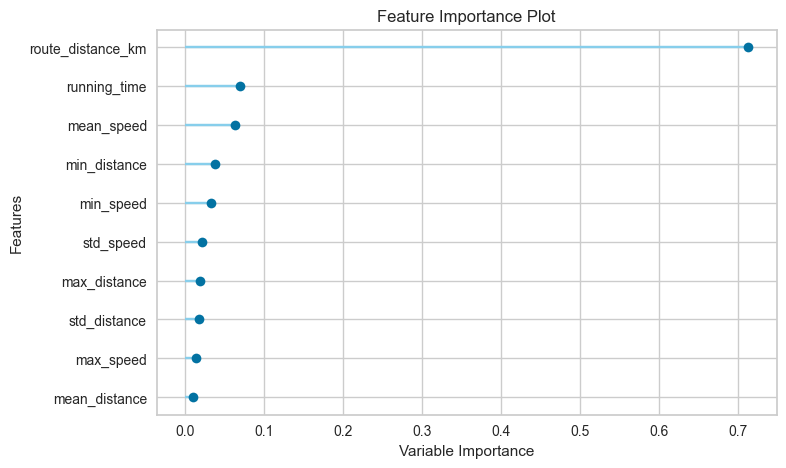

In [446]:
plot_model(tuned_best_model, 'feature')

In [ ]:
interpret_model(tuned_best_model)

In [447]:
# validate on unseen data
unseen_predictions = predict_model(tuned_best_model, data=data_unseen)
unseen_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1748,0.0541,0.2326,0.6466,0.0326,0.0281


,is_rush_hour,running_time,route_distance_km,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed,delta_time,prediction_label
0,0.0,1.643003e+09,3.976,4.041858,250.030594,57.799480,56.929813,17.0,67.0,39.142857,11.990396,6.542472,6.342125
1,0.0,1.642997e+09,9.266,0.671740,141.949554,34.466267,30.002520,18.0,72.0,39.687500,12.381357,6.854354,6.696938
2,0.0,1.642989e+09,7.306,1.463446,327.558411,31.970552,43.610020,22.0,82.0,45.422871,12.630840,6.735780,6.545374
3,0.0,1.643001e+09,3.252,1.895423,153.114700,31.479698,33.019516,12.0,45.0,30.465517,7.760032,6.204558,6.269941
4,0.0,1.643028e+09,1.592,3.047062,122.859138,44.798424,42.421276,24.0,36.0,28.666666,3.084664,6.006353,5.636756
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1.0,1.643008e+09,3.728,1.514582,156.829193,36.636948,36.653244,18.0,42.0,28.930233,5.116963,6.493754,6.476608
495,1.0,1.643053e+09,1.606,4.080960,146.609161,44.612850,36.440327,16.0,54.0,41.875000,11.022950,5.609472,5.631331
496,1.0,1.643015e+09,3.237,0.689367,181.134781,26.553898,28.394712,17.0,41.0,30.500000,6.043790,6.878326,6.422928
497,1.0,1.643046e+09,7.246,0.671740,209.662903,40.684753,43.883514,16.0,39.0,26.817074,6.154649,6.792345,6.827552


In [448]:
(mean_squared_error(np.expm1(unseen_predictions['delta_time']), np.expm1(unseen_predictions['prediction_label']), squared=False))

125.67650995116698

### Model predictions on test data

In [423]:
test_dataset = pd.read_csv("datasets/big-table-test.csv")
test_dataset = test_dataset.drop(columns=USELESS_COLUMNS)

test_dataset

,Id,running_time,route_distance_km,distance,speed,is_work_hour,is_night_time,is_late_night_time,is_rush_hour,humidity,visibility,windspeedKmph,tempC,weatherStatus
0,6198,2022-01-24 03:38:30,4.744,138.795710,37.0,0,0,1,0,84,10,24,-5,Clear
1,6198,2022-01-24 03:38:30,4.744,95.273001,33.0,0,0,1,0,84,10,24,-5,Clear
2,6198,2022-01-24 03:38:30,4.744,137.647881,35.0,0,0,1,0,84,10,24,-5,Clear
3,6198,2022-01-24 03:38:30,4.744,4.383708,30.0,0,0,1,0,84,10,24,-5,Clear
4,6198,2022-01-24 03:38:30,4.744,24.195593,31.0,0,0,1,0,84,10,24,-5,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102537,527850,2022-01-24 18:45:20,10.127,40.933260,45.0,1,0,0,1,87,10,18,-4,Light snow
102538,527850,2022-01-24 18:45:20,10.127,63.421598,34.0,1,0,0,1,87,10,18,-4,Light snow
102539,527850,2022-01-24 18:45:20,10.127,4.303810,16.0,1,0,0,1,87,10,18,-4,Light snow
102540,527850,2022-01-24 18:45:20,10.127,5.250640,37.0,1,0,0,1,87,10,18,-4,Light snow


In [424]:
prediction_agg = test_dataset.groupby([*FEATURE_COLUMNS, *['Id', 'running_time', 'route_distance_km']]) \
    .agg({'distance': ['min', 'max', 'mean', 'std'], 'speed': ['min', 'max', 'mean', 'std']}).reset_index()

prediction_agg = prediction_agg.drop(columns=['Id'])
prediction_agg['running_time'] = (pd.to_datetime(prediction_agg['running_time']) - datetime.datetime(1970,1,1)).dt.total_seconds()
prediction_agg['delta_time'] = 0

In [425]:
prediction_agg = pd.DataFrame(prediction_agg.values, columns=INCLUDE_COLUMNS)

In [426]:
data_prediction = prediction_agg
data_prediction.reset_index(drop=True, inplace=True)

In [427]:
submission_df = pd.read_csv("datasets/submission.csv")
submission_df

,Id,Predicted
0,6198,0
1,6417,0
2,7054,0
3,9628,0
4,10283,0
...,...,...
995,525706,0
996,526604,0
997,527213,0
998,527520,0


In [428]:
submission_predictions = predict_model(tuned_best_model, data=data_prediction)
submission_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.8989,26.3049,5.1288,-10.4573,1.2987,12.3367


,running_time,route_distance_km,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed,delta_time,prediction_label
0,1.642995e+09,4.744,393.497711,52.880474,61.845188,14.0,72.0,47.573032,12.983283,0.0,2.670344,6.470852
1,1.642996e+09,6.279,436.138855,36.270615,46.198627,14.0,65.0,41.424419,11.920795,0.0,2.836942,6.491480
2,1.642996e+09,3.934,292.340759,55.012733,58.488518,21.0,56.0,39.929577,9.457157,0.0,0.857178,6.213302
3,1.642997e+09,5.959,247.943665,33.236916,37.770878,6.0,61.0,37.832401,11.829541,0.0,0.306712,6.614740
4,1.642997e+09,7.028,203.740570,36.920700,40.248516,13.0,68.0,38.363159,12.544933,0.0,0.153356,6.598037
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.643050e+09,2.897,274.618378,48.263069,55.255577,14.0,54.0,38.116665,11.370630,0.0,4.078611,6.381093
996,1.643050e+09,3.482,233.844635,38.275375,41.604237,11.0,58.0,37.021976,10.375160,0.0,3.207770,6.598014
997,1.643050e+09,3.486,137.592957,27.527613,25.461119,9.0,57.0,36.816002,9.140820,0.0,1.974970,6.603665
998,1.643050e+09,0.703,126.478058,31.932693,34.065372,23.0,53.0,35.818180,9.624554,0.0,2.004086,5.501732


In [429]:
result_df = submission_predictions["prediction_label"].reset_index()

In [430]:
submission_df["Predicted"] = np.expm1(result_df["prediction_label"])

In [431]:
submission_df.to_csv("datasets/submission.csv", index=False)

## Submission phase

Guide: https://www.kaggle.com/code/derrickmwiti/how-to-make-submissions-using-kaggle-s-api/notebook

In [ ]:
!pip install kaggle

In [432]:
import os
os.environ["KAGGLE_USERNAME"]="beardimon"
os.environ["KAGGLE_KEY"]="22adc3776f244a54f4732bf8dfb077eb"

In [433]:
!kaggle competitions submit -c int20h-2023-hackathon  -f ./datasets/submission.csv -m "Baseline"

100%|██████████████████████████████████████| 24.4k/24.4k [00:01<00:00, 16.8kB/s]
Successfully submitted to INT20H 2023 Hackathon

In [434]:
!kaggle competitions leaderboard -c int20h-2023-hackathon --show

 teamId  teamName  submissionDate       score    
-------  --------  -------------------  -------  
9989061  Leopards  2023-03-05 01:37:57  0.00000  
9988950  4NN       2023-03-05 01:22:46  0.00000  


In [435]:
!kaggle competitions submissions -c int20h-2023-hackathon

fileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
submission.csv  2023-03-05 01:37:57  Baseline     complete  0.00000                    
submission.csv  2023-03-04 17:52:35  Baseline     complete  0.00000                    
submission.csv  2023-03-04 17:38:47  Baseline     complete  0.00000                    
submission.csv  2023-03-04 17:28:51  Baseline     error                                
